### Basic Imports

In [35]:
!pip install pytorch_lightning
import numpy as np
import pandas as pd
import random
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import seaborn as sns



Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


### Potato Diseases Datasets

#### Path Import

In [9]:
data_path = '/openbayes/input/input0'

In [10]:
classes = os.listdir(data_path)

class_images = {}

for i in classes:
    
    class_images[i] = random.sample(os.listdir(os.path.join(data_path, i)), 5)

In [11]:
class_images

{'Healthy Potatoes': ['66.jpg', '41.jpg', '46.jpg', '11.jpg', '51.jpg'],
 'Dry Rot': ['11.jpg', '30.jpg', '59.jpg', '58.jpg', '5.jpg'],
 'Black Scurf': ['20.jpg', '45.jpg', '4.jpg', '25.jpg', '11.jpg'],
 'Common Scab': ['16.jpg', '37.jpg', '23.jpg', '36.jpg', '15.jpg'],
 'Blackleg': ['32.jpg', '49.jpg', '31.jpg', '27.jpg', '55.jpg'],
 'Miscellaneous': ['31.jpg', '60.jpg', '12.jpg', '33.jpg', '2.jpg'],
 'Pink Rot': ['52.jpg', '56.jpg', '10.jpg', '31.jpg', '38.jpg']}

#### Image Illustration  (这里如果报错就重新从Path Import这里重新run一遍)

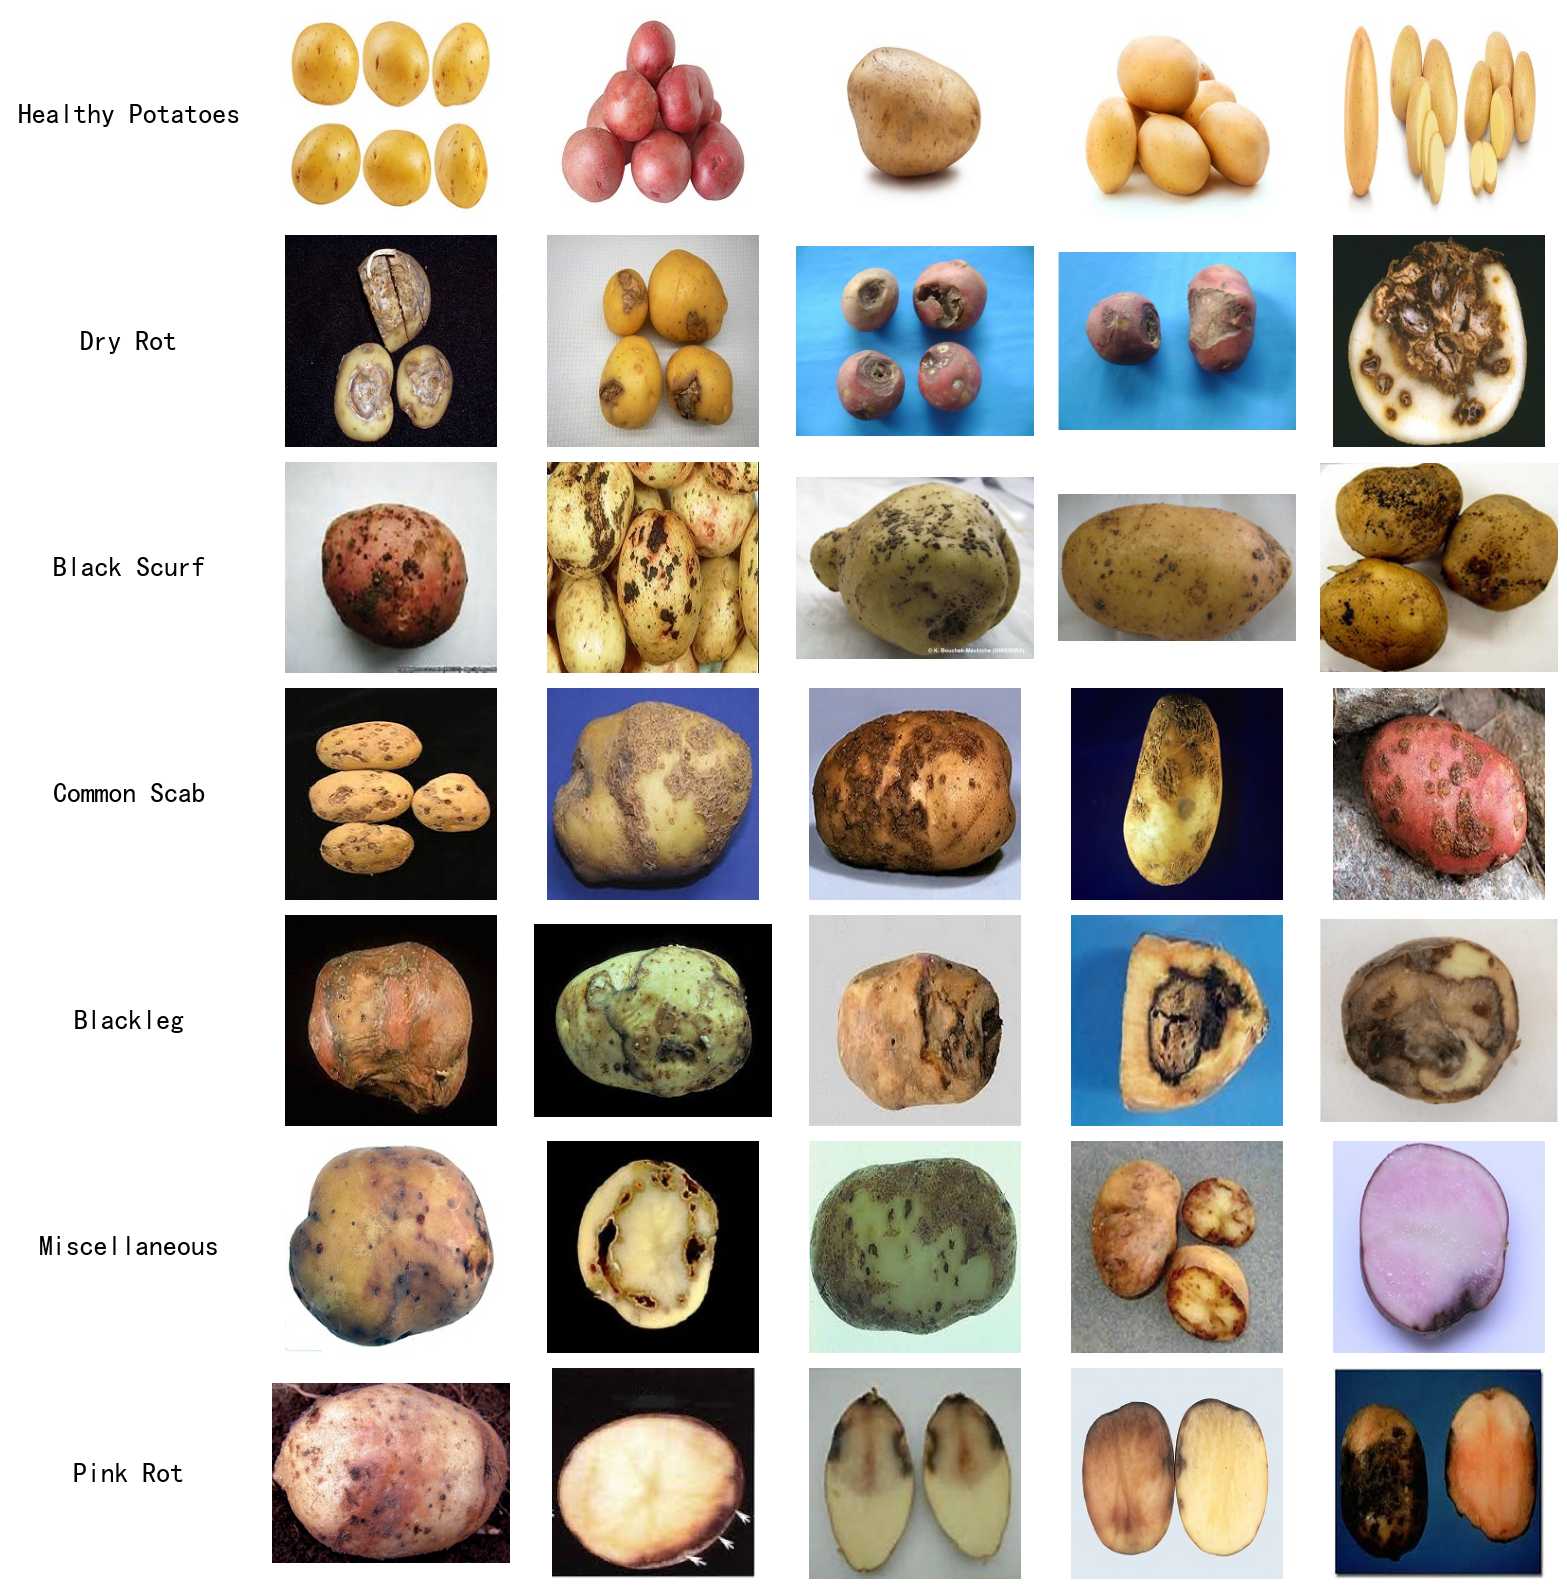

In [12]:
fig, ax = plt.subplots(7, 6, figsize=(16, 16))

# Loop through each class and its images
for i, class_name in enumerate(class_images):
    
    # Display the class name before each row
    ax[i, 0].text(0.5, 0.5, class_name, fontsize=20, ha='center', va='center', transform=ax[i, 0].transAxes)
    ax[i, 0].axis('off')
    
    for j, file in enumerate(class_images[class_name]):
        # Load and display the image
        image = cv2.imread(os.path.join(data_path, class_name, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i, j + 1].imshow(image)
        ax[i, j + 1].axis('off')
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


#### Check number of images in each class

In [13]:
for i in os.listdir(data_path):
    length = len(os.listdir(os.path.join(data_path, i)))
    print('{} = {} Images'.format(i, length))

Healthy Potatoes = 80 Images
Dry Rot = 60 Images
Black Scurf = 58 Images
Common Scab = 62 Images
Blackleg = 60 Images
Miscellaneous = 74 Images
Pink Rot = 57 Images


In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

#### Device

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Transform

In [16]:
data_transforms = transforms.Compose([    
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

#### Dataset Preparation

In [17]:
path = '/openbayes/input/input0'

image_datasets = datasets.ImageFolder(path, data_transforms)

train_size = int(0.8 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_datasets, test_datasets = torch.utils.data.random_split(image_datasets, [train_size, test_size])

cal_size = int(0.2 * train_size)
train_size = train_size - cal_size
cal_datasets, train_datasets = torch.utils.data.random_split(train_datasets, [cal_size, train_size])

dataloader = {}

dataloader['train'] = DataLoader(train_datasets, batch_size = 4, shuffle= True, num_workers = 4)
dataloader['test'] = DataLoader(test_datasets, batch_size = 4, shuffle= True, num_workers = 4)
dataloader['cal'] =  DataLoader(cal_datasets, batch_size = 4, shuffle= True, num_workers = 4)

dataset_sizes = {}

dataset_sizes['train'] = len(train_datasets)
dataset_sizes['test'] = len(test_datasets)
dataset_sizes['cal'] = len(cal_datasets)

class_names = image_datasets.classes

#### model training and testing

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            if epoch%10 == 0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)
            
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                if epoch%10 == 0:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    torch.save(model.state_dict(),"/openbayes/home/Potato/model.pth")    
    
    return model

#### Loss Function and Optimizer

In [19]:
model_ft = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_Potato = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 3.8366 Acc: 0.2951
test Loss: 2.4414 Acc: 0.3297
Epoch 10/199
----------
train Loss: 0.8653 Acc: 0.6736
test Loss: 1.0906 Acc: 0.5604
Epoch 20/199
----------
train Loss: 0.8513 Acc: 0.7396
test Loss: 0.9737 Acc: 0.6703
Epoch 30/199
----------
train Loss: 0.9302 Acc: 0.6736
test Loss: 1.2396 Acc: 0.5495
Epoch 40/199
----------
train Loss: 0.9096 Acc: 0.7083
test Loss: 1.1964 Acc: 0.6044
Epoch 50/199
----------
train Loss: 0.8673 Acc: 0.6944
test Loss: 1.2106 Acc: 0.6044
Epoch 60/199
----------
train Loss: 0.8660 Acc: 0.6944
test Loss: 1.2688 Acc: 0.5495
Epoch 70/199
----------
train Loss: 0.8760 Acc: 0.7153
test Loss: 1.0708 Acc: 0.6044
Epoch 80/199
----------
train Loss: 0.8489 Acc: 0.7049
test Loss: 1.1149 Acc: 0.6044
Epoch 90/199
----------
train Loss: 0.8279 Acc: 0.6979
test Loss: 1.1372 Acc: 0.5934
Epoch 100/199
----------
train Loss: 0.9001 Acc: 0.6806
test Loss: 1.1548 Acc: 0.5824
Epoch 110/199
----------
train Loss: 0.7900 Acc: 0.7569
test Loss

#### Loading model weight

In [28]:
model_path = '/openbayes/home/Potato/model.pth'
model_ft.load_state_dict(torch.load(model_path))
model_Potato = model_ft

#### Conformal Prediction

In [51]:
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import ClassWisePredictor

# Preparing a calibration data and a test data.
cal_dataloader = dataloader['cal']
test_dataloader = dataloader['test']
# Preparing a pytorch model
model = model_Potato

model.eval()
score_functions = [THR(), APS()]
coverage_rates = []
average_sizes = []
# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusterPredictor, ClassWisePredictor
for score in score_functions:
    predictor = ClassWisePredictor(score_function=score, model=model)

# Calibrating the predictor with significance level as 0.1
    predictor.calibrate(cal_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# for batch in test_dataloader:
#    test_instances , _ = batch
#    predict_sets = predictor.predict(test_instances)
#    print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
    result_dict = predictor.evaluate(test_dataloader)
    coverage_rates.append(result_dict["Coverage_rate"])
    average_sizes.append(result_dict["Average_size"])
    print(result_dict["Coverage_rate"], result_dict["Average_size"])

0.9340659340659341 997.4285714285714
0.967032967032967 997.0879120879121


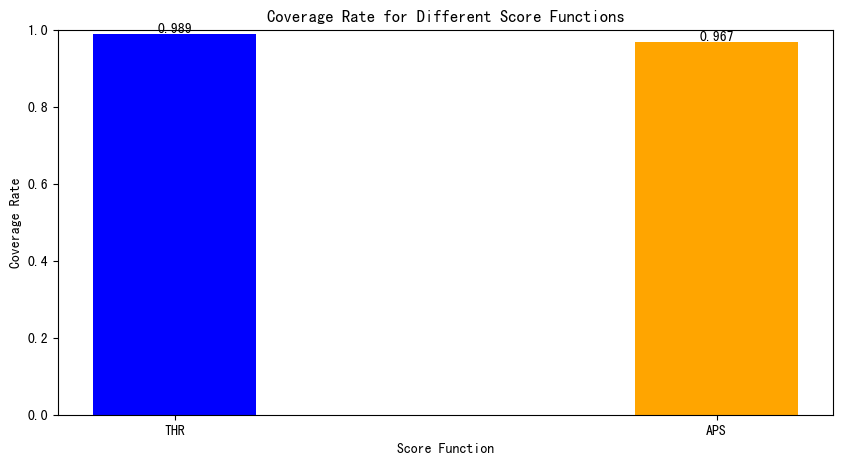

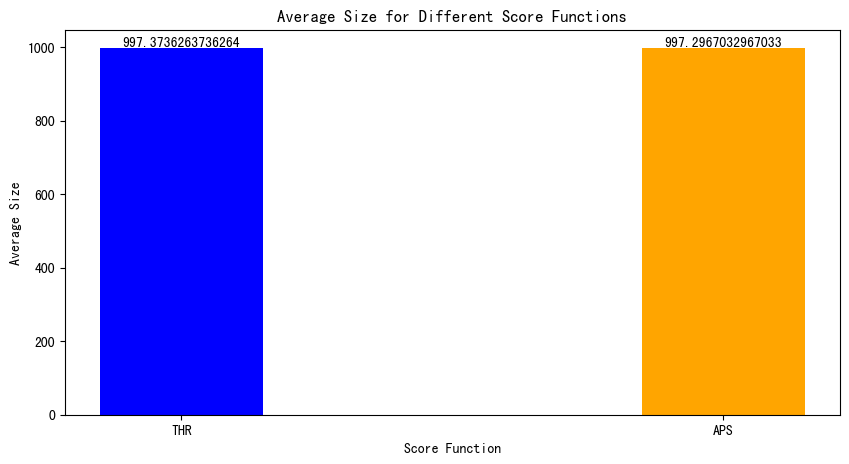

In [49]:


# Assuming you have data for different score functions, Coverage_rate, and Average_size
score_functions = ['THR', 'APS']

# Create a DataFrame for easier plotting

# 绘制Coverage_rate图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, coverage_rates, color=['blue', 'orange'], width=0.3)
plt.title('Coverage Rate for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Coverage Rate')
plt.ylim(0, 1)  # 设置y轴范围为0到1

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, coverage_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')
plt.savefig('/openbayes/home/Potato/Coverage_Rates.png')
plt.show()

# 绘制Average_size图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, average_sizes, color=['blue', 'orange'], width=0.3)
plt.title('Average Size for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Average Size')

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, average_sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value}', ha='center', va='bottom')
plt.savefig('/openbayes/home/Potato/average_sizes.png')
plt.show()